In [1]:
using Flux
using LinearAlgebra: ⋅

"""
    Hamiltonian
"""
mutable struct Hamiltonian
  epsilon::Float32
  delta::Float32
  momentum::IdDict
end

Hamiltonian(ϵ=1.0, δ=0.6) = Hamiltonian(ϵ, δ, IdDict())

function Flux.Optimise.apply!(o::Hamiltonian, x, Δ)
    ϵ, δ = o.epsilon, o.delta
    p = get!(o.momentum, x, zero(x))
    @. p *= δ
    @. p -= ϵ * δ * Δ

    o.momentum[x] = p
    sqsum = p ⋅ p
    @. Δ = - ϵ / (1.0 + sqsum) * p
    return Δ
end

In [2]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated
using Dates: now, value
using Printf: @printf
using CuArrays

# Classify MNIST digits with a simple multi-layer-perceptron

imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) |> gpu

labels = MNIST.labels()
# One-hot-encode the labels
Y = onehotbatch(labels, 0:9) |> gpu

m = Chain(
  Dense(28^2, 500, relu),
  Dense(500, 500, relu),
  Dense(500, 10),
  softmax) |> gpu

loss(x, y) = crossentropy(m(x), y)
#bug
#accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))
function accuracy(x,y)
    match = .0
    count = .0
    for i in 1:size(x,2)
        count += 1
        match += onecold(m(x[:,i])) == onecold(y[:,i]) ? 1 : 0
    end
    return match/count
end
        


logs = []
function eval_log()
    elapsed = now()-st # millisecond
    global logs
    #@printf("%g %f\n", loss(X, Y).data, value(elapsed)/1000.0)
    if size(logs,1) != 0
        logs = vcat(logs, [loss(X, Y).data value(elapsed)/1000.0])
    else
        logs = [loss(X, Y).data value(elapsed)/1000.0]
    end
end
evalcb = () -> eval_log()

opt = Hamiltonian()
dataset = [ (X[:,100i-99:100i],Y[:,100i-99:100i]) for i in 1:600]

st = now()
for j in 1:100
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 1))
end

@show accuracy(X, Y)

# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...) |> gpu
tY = onehotbatch(MNIST.labels(:test), 0:9) |> gpu

@show accuracy(tX, tY)

┌ Warning: Flux is only supported with CuArrays v0.9.
│ Try running `] pin CuArrays@0.9`.
└ @ Flux.CUDA /home/satot/.julia/packages/Flux/Jjxnn/src/cuda/cuda.jl:12


accuracy(X, Y) = 1.0
accuracy(tX, tY) = 0.9847


0.9847

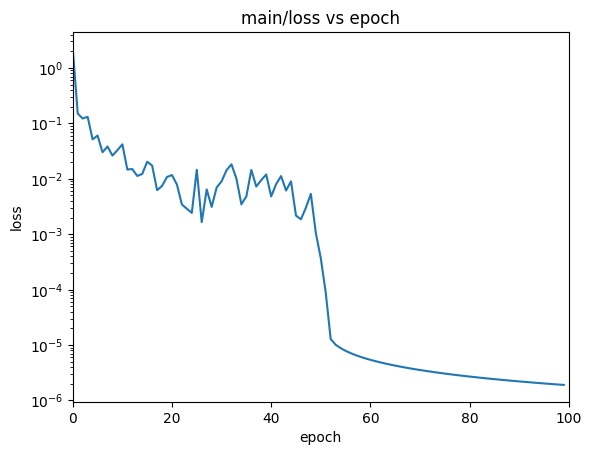

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8ff09440b8>

In [3]:
using PyPlot
yscale("log")
xlim(0,100)
title("main/loss vs epoch")
xlabel("epoch")
ylabel("loss")
plot(logs[:,1])

In [4]:

#https://github.com/JuliaData/DataFrames.jl/issues/873
using JSON
using Lazy
using DataFrames

function readjson(filename::String)
  rawdata = JSON.parsefile(filename)
  names = @as file rawdata begin
                map(keys,file)
                vcat([[i...] for i in file]...)
                unique(file)
          end
  df = DataFrame()
  for name in names
    df[Symbol(name)] = map(rawdata) do obj
      haskey(obj,name) ? obj[name] : NA
    end
    for i in 1:length(df[Symbol(name)])
      if df[Symbol(name)][i] == nothing
        df[Symbol(name)][i] = NA
      end
    end
  end
  return df
end

Hamil_json = readjson("python/result/Hamiltonian")

loaded


,validation/main/loss,main/loss,validation/main/accuracy,epoch,iteration,elapsed_time,main/accuracy
,Float64,Float64,Float64,Int64,Int64,Float64,Float64
1,0.142981,0.22852,0.9552,1,600,2.59328,0.93005
2,0.112906,0.0942141,0.9648,2,1200,5.18347,0.970465
3,0.0826599,0.0635771,0.9753,3,1800,7.77787,0.979649
4,0.112776,0.0448988,0.9667,4,2400,10.3716,0.985749
5,0.0749565,0.037517,0.9789,5,3000,12.9731,0.987716
6,0.0804622,0.0270637,0.9794,6,3600,15.5699,0.991315
7,0.0865805,0.0238665,0.9777,7,4200,18.1592,0.992615
8,0.0842367,0.0203656,0.9814,8,4800,20.7674,0.993532
9,0.0838823,0.0169976,0.9792,9,5400,23.3587,0.994698


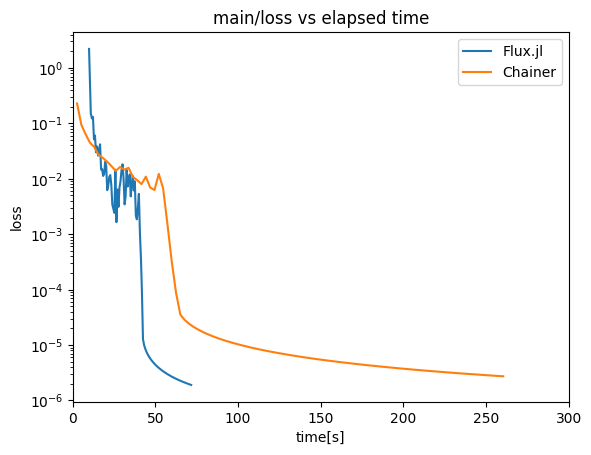

PyObject <matplotlib.legend.Legend object at 0x7f8fdc752400>

In [5]:
yscale("log")
xlim(0,300)
title("main/loss vs elapsed time")
xlabel("time[s]")
ylabel("loss")
plot(logs[:,2],logs[:,1],label="Flux.jl")
plot(Hamil_json[:elapsed_time], Hamil_json[Symbol("main/loss")],label="Chainer")
legend()